In [48]:
import pandas as pd
import numpy as np
import seaborn as sbr
import matplotlib as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
from sklearn.utils import shuffle as sk_shuffle
from PIL import Image 

df = pd.read_csv("housing_progettofinale.csv")
df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,2
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,1,0,1,0,0,2,0,0
541,1767150,2400,3,1,1,0,0,0,0,0,0,0,2
542,1750000,3620,2,1,1,1,0,0,0,0,0,0,0
543,1750000,2910,3,1,1,0,0,0,0,0,0,0,1


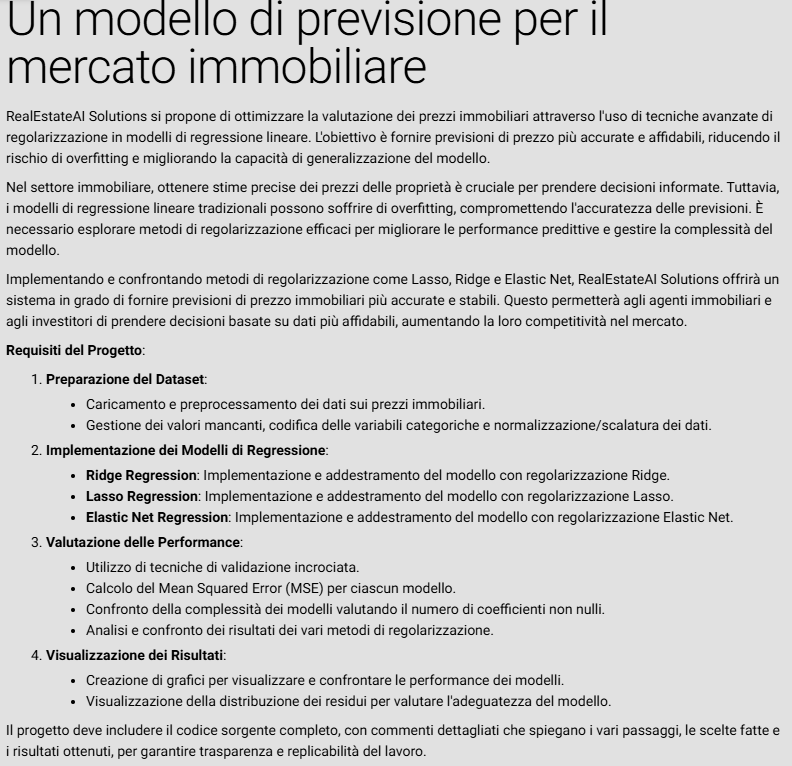

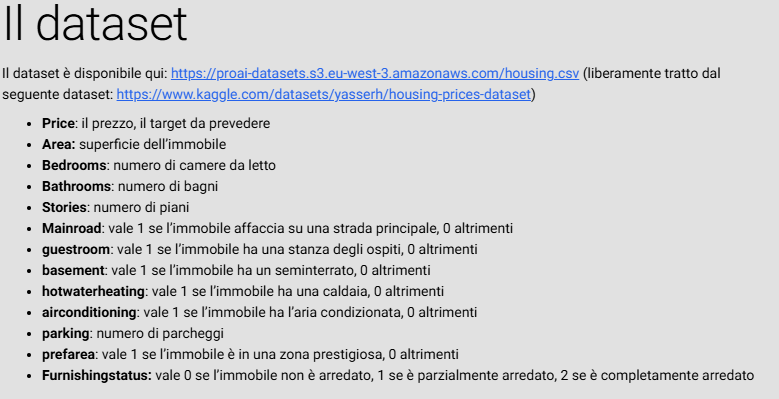

In [30]:
img1 = Image.open('Previsione_Mercato_immobiliare1.png')
img2 = Image.open('Previsione_Mercato_immobiliare2.png')
img1.show()
img2.show()

CREO TUTTE LE FUNZIONI NECESSARIE PER SVOLGERE L'ESERCIZIO

In [31]:
def feature_analisi(df: pd.DataFrame, ordine: str = "% Nulli", ascending: bool = False) -> pd.DataFrame:
    """
    Ritorna info sulle colonne del DataFrame:
    - Tipo colonna
    - N. valori nulli
    - % valori nulli
    - N. valori unici
    - % valori unici
    - Valore minimo (per colonne numeriche)
    - Valore massimo (per colonne numeriche)

    Parametri:
    - ordine: colonna di ordinamento ("% Nulli" o "% Unici")
    - ascending: True per ordine crescente, False per decrescente (default)
    """
    n_rows = len(df)
    null_count = df.isnull().sum()
    null_percent = (null_count / n_rows) * 100
    dtypes = df.dtypes.astype(str)
    unique_count = df.nunique()
    unique_percent = (unique_count / n_rows) * 100

    # Calcolo minimo e massimo solo per colonne numeriche
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    min_values = df[numeric_cols].min().reindex(df.columns, fill_value=np.nan)
    max_values = df[numeric_cols].max().reindex(df.columns, fill_value=np.nan)

    risultato = pd.DataFrame({
        "Colonna": df.columns,
        "Tipo": dtypes,
        "N Nulli": null_count,
        "% Nulli": null_percent.round(2),
        "N Unici": unique_count,
        "% Unici": unique_percent.round(2),
        "Min": min_values,
        "Max": max_values
    })

    if ordine not in ["% Nulli", "% Unici"]:
        raise ValueError("Il parametro 'ordine' deve essere '% Nulli' oppure '% Unici'.")

    risultato = risultato.sort_values(by=ordine, ascending=ascending).reset_index(drop=True)

    return risultato

def MatriceCorrelazione(df):
    """Heatmap delle correlazioni da df+features oppure da X.

    Ritorna la matrice di correlazione (pd.DataFrame) e mostra la figura.
    """
    corr = df.corr(method="pearson")
    plt.figure(figsize=(12, 10))
    sbr.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
    plt.title(f"Matrice di correlazione (pearson)")
    plt.tight_layout()
    plt.show()
    return corr

def DistribuzioneFeature(df: pd.DataFrame, feature: str, bins: int = 30) -> None:
    """Istogramma della distribuzione di una feature numerica."""
    if feature not in df.columns:
        raise ValueError(f"La feature '{feature}' non è presente nel DataFrame.")
    col = feature  # o qualsiasi altra feature
    plt.figure(figsize=(8,5))
    sbr.histplot(df[col], bins=30, kde=True)  # kde=True aggiunge la curva stimata
    plt.title(f"Distribuzione di {col}")
    plt.xlabel(col)
    plt.ylabel("Frequenza")
    plt.show()

def get_model(model_name, **kwargs):
    """
    Restituisce un modello sklearn 'vuoto' (non fittato) in base al nome scelto.

    📌 Parametri:
    - model_name (str): Nome del modello desiderato. Opzioni disponibili:
        • 'linear'         → Regressione lineare semplice (Ordinary Least Squares)
        • 'ridge'          → Ridge Regression (L2)
            - kwargs: alpha (default 1.0)
        • 'lasso'          → Lasso Regression (L1)
            - kwargs: alpha (default 1.0)
        • 'elasticnet'     → Elastic Net (combinazione L1 + L2)
            - kwargs:
                - alpha (default 1.0): peso complessivo della regolarizzazione
                - l1_ratio (default 0.5): rapporto tra L1 e L2
        • 'random_forest'  → Random Forest Regressor
            - kwargs più comuni:
                - n_estimators (default 100)
                - max_depth (default None)
                - random_state (default 42)
        • 'gboost'        → Gradient Boosting Regressor
            - kwargs più comuni:
                - n_estimators (default 100)
                - learning_rate (default 0.1)
                - max_depth (default 3)
                - random_state (default 42)
        • 'svr'           → Support Vector Regressor
            - kwargs più comuni:
                - C (default 1.0)
                - kernel (default 'rbf')
                - epsilon (default 0.1)

    📈 Output:
    - Un'istanza del modello sklearn, pronta per essere fittata con .fit(X_train, y_train).

    ❗ Nota:
    - Questa funzione NON esegue fit: restituisce il modello inizializzato.
    - Puoi passare ulteriori iperparametri personalizzati con kwargs.

    Esempi:
    --------
    >>> get_model('ridge', alpha=10)
    Ridge(alpha=10)

    >>> get_model('elasticnet', alpha=0.5, l1_ratio=0.7)
    ElasticNet(alpha=0.5, l1_ratio=0.7)

    """
    model_name = model_name.lower()

    if model_name == 'linear':
        return LinearRegression(**kwargs)
    elif model_name == 'ridge':
        return Ridge(**kwargs)
    elif model_name == 'lasso':
        return Lasso(**kwargs)
    elif model_name == 'elasticnet':
        return ElasticNet(**kwargs)
    else:
        raise ValueError(f"Modello '{model_name}' non riconosciuto. Usa help(get_model) per vedere le opzioni disponibili.")

def ValutaModelloResidui(model, X_train, X_test, y_train, y_test, random_state=42, standardizza=False):
    """
    Valuta un modello sklearn con train/test split, metriche e analisi dei residui.

    📌 Parametri:
    - model: modello sklearn già istanziato (es. LinearRegression()).
    - X, y: dati di input e target (numpy array o pandas DataFrame/Series).
    - test_size: proporzione del test set (default 0.2).
    - random_state: per la riproducibilità.
    - standardizza: se True, standardizza X con StandardScaler.

    📈 Output:
    - Stampa metriche: MAE, MSE, RMSE, R² train e test.
    - Mostra:
        1. Distribuzione residui test
        2. Grafico residui vs predetti (test)

    📊 Distribuzione dei residui (Istogramma)

    Cosa cercare: E' la distribuzione dell'errore, se non ci sono bias (cioè il modello tende a sbagliare in positivo o in negativo) la distribuzione dovrebbe essere normale
    📈 Residui vs. Valori Predetti (Grafico a dispersione)

    Cosa cercare: E' la relazione previsione/errore, la domanda da porsi è, tende a sbagliare di piu su una certa fascia di previsioni? Non dovrebbe, l'errore dovrebbe essere casuale a tutte le scale

    ✅ In sintesi:

    La distribuzione dei residui è centrata e ragionevolmente casuale → bene.

    Il grafico residui vs predetti non mostra pattern evidenti → buona omoschedasticità.

    Non ci sono segnali gravi di bias o problemi strutturali nel modello.
    """
    from sklearn.preprocessing import StandardScaler

    # ⚙️ Standardizzazione opzionale
    if standardizza:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # 🧠 Fit modello
    model.fit(X_train, y_train)

    # 🔮 Predizioni
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # 📊 Metriche
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_train, y_train_pred)

    mae_test = mean_absolute_error(y_test, y_test_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, y_test_pred)

    print(f"📈 TRAIN")
    print(f"MAE:  {mae_train:.4f}")
    print(f"MSE:  {mse_train:.4f}")
    print(f"RMSE: {rmse_train:.4f}")
    print(f"R²:   {r2_train:.4f}")
    print("-" * 40)
    print(f"🧪 TEST")
    print(f"MAE:  {mae_test:.4f}")
    print(f"MSE:  {mse_test:.4f}")
    print(f"RMSE: {rmse_test:.4f}")
    print(f"R²:   {r2_test:.4f}")

    # 📉 Residui su test
    residui_test = y_test - y_test_pred

    # Istogramma residui
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.histplot(residui_test, kde=True)
    plt.axvline(0, color='red', linestyle='--')
    plt.title('Distribuzione residui (Test)')
    plt.xlabel('Residuo')
    plt.ylabel('Frequenza')

    # Scatter residui vs predetti
    plt.subplot(1,2,2)
    plt.scatter(y_test_pred, residui_test, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residui vs Predetti (Test)')
    plt.xlabel('Valori predetti')
    plt.ylabel('Residui')

    plt.tight_layout()
    plt.show()

def cross_validate_kfold(model, X, y, k=5, random_state=0, shuffle=True):
    """
    Esegue K-Fold Cross Validation con standardizzazione corretta per ogni fold.

    ⚙️ Funzionamento:
    - Divide il dataset in k fold usando KFold.
    - Per ogni fold:
        1. Separa train e test.
        2. Fitta lo StandardScaler sul TRAIN.
        3. Trasforma train e test con quello scaler (senza refit sul test!).
        4. Allena il modello sul train standardizzato.
        5. Valuta sul test standardizzato usando R² (puoi cambiare metrica se vuoi).
    - Restituisce dizionario con score per ogni fold, media train e test.

    📌 Parametri:
    - model: modello scikit-learn già istanziato (es. LinearRegression()).
    - X, y: dati (può essere numpy array o pandas DataFrame/Series).
    - k: numero di fold.
    - random_state, shuffle: controllano la riproducibilità degli split.

    📈 Output:
    - Dizionario con:
        'train_scores': array degli score sul train di ogni fold
        'test_scores': array degli score sul test di ogni fold
        'train_mean': media degli score train
        'test_mean': media degli score test
    """
    kf = KFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    train_scores = []
    test_scores = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Standardizzazione per fold
        scaler = StandardScaler()
        X_train_std = scaler.fit_transform(X_train)
        X_test_std = scaler.transform(X_test)

        # Fit e predizioni
        model.fit(X_train_std, y_train)
        y_train_pred = model.predict(X_train_std)
        y_test_pred = model.predict(X_test_std)

        # Score
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        train_scores.append(train_r2)
        test_scores.append(test_r2)

    results = {
        'train_scores': np.array(train_scores),
        'test_scores': np.array(test_scores),
        'train_mean': np.mean(train_scores),
        'test_mean': np.mean(test_scores)
    }

    return results

def plot_r2_vs_alpha(model, X_train, X_test, y_train, y_test, alphas = np.logspace(-3, 2, 20)):
    """
    Traccia la curva R² (train e test) al variare di alpha per il modello fornito.

    📌 Parametri:
    - model: modello sklearn 'vuoto' (es. Lasso(), Ridge(), ElasticNet(), ecc.)
             Deve avere l'attributo 'alpha'.
    - X_train, X_test, y_train, y_test: dati già pronti (già standardizzati se serve).
    - alphas: lista o array di valori di alpha da testare.

    📈 Output:
    - Grafico R² train/test vs alpha (scala logaritmica sull'asse x)

    👉 La funzione NON modifica il modello originale: ne crea una copia per ogni alpha.
    """
    train_scores = []
    test_scores = []

    for alpha in alphas:
        # Copia del modello per non modificare quello originale
        m = deepcopy(model)

        # Aggiorna alpha per il modello corrente
        if hasattr(m, 'alpha'):
            m.alpha = alpha
        else:
            raise ValueError("Il modello passato non ha l'attributo 'alpha'.")

        # Fit e predizioni
        m.fit(X_train, y_train)
        y_train_pred = m.predict(X_train)
        y_test_pred = m.predict(X_test)

        # Calcolo R²
        train_scores.append(r2_score(y_train, y_train_pred))
        test_scores.append(r2_score(y_test, y_test_pred))

    # 📊 Plot
    plt.figure(figsize=(8,5))
    plt.semilogx(alphas, train_scores, label='Train R²', marker='o')
    plt.semilogx(alphas, test_scores, label='Test R²', marker='s')
    plt.xlabel('Alpha (log scale)')
    plt.ylabel('R²')
    plt.title(f'Curva R² vs Alpha - {model.__class__.__name__}')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.show()

def plot_learning_curve(model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), k=5, random_state=42):
    """
    Traccia la curva di apprendimento utilizzando la funzione cross_validate_kfold.

    📌 Parametri:
    - model: modello sklearn non fittato
    - X, y: dataset completo (numpy array o DataFrame)
    - train_sizes: frazioni del dataset da usare per i vari step (0-1)
    - k: numero di fold per la cross validation interna
    - random_state: per la riproducibilità del campionamento

    📈 Output:e
    - Plot con train_mean e test_mean in funzione della dimensione del training set.
    """
    n_samples = X.shape[0]
    train_sizes_abs = (train_sizes * n_samples).astype(int)

    train_scores = []
    test_scores = []

    # Shuffle fisso per avere consistenza
    X_shuf, y_shuf = sk_shuffle(X, y, random_state=random_state)

    for size in train_sizes_abs:
        # Prendi un sottoinsieme del dataset
        X_subset = X_shuf[:size]
        y_subset = y_shuf[:size]

        # Usa la funzione già definita
        results = cross_validate_kfold(model, X_subset, y_subset, k=k, random_state=random_state)

        train_scores.append(results['train_mean'])
        test_scores.append(results['test_mean'])

    # 📈 Plot
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes_abs, train_scores, 'o-', label='Train score')
    plt.plot(train_sizes_abs, test_scores, 's-', label='CV score')
    plt.xlabel('Numero di campioni nel training set')
    plt.ylabel('R²')
    plt.title(f'Curva di apprendimento (Custom CV) - {model.__class__.__name__}')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

In [32]:
feature_analisi(df)
#Non ci sono valori Nan in nessuna feature e sono tutti valori interi, i dati sembrano essere gia puliti, non ho bisogno della moda o della media per riempire i Nan
# Anche per quanto riguarda l'encoding abbiamo tutte feature vero/falso quindi on/off di caratteristiche come se one hot encoding sia gia stato fatto, Furnishingstatus è ordinabile è gia stata fatta la label encoding

,Colonna,Tipo,N Nulli,% Nulli,N Unici,% Unici,Min,Max
0,price,int64,0,0.0,219,40.18,1750000,13300000
1,area,int64,0,0.0,284,52.11,1650,16200
2,bedrooms,int64,0,0.0,6,1.10,1,6
3,bathrooms,int64,0,0.0,4,0.73,1,4
4,stories,int64,0,0.0,4,0.73,1,4
5,mainroad,int64,0,0.0,2,0.37,0,1
6,guestroom,int64,0,0.0,2,0.37,0,1
7,basement,int64,0,0.0,2,0.37,0,1
8,hotwaterheating,int64,0,0.0,2,0.37,0,1
9,airconditioning,int64,0,0.0,2,0.37,0,1


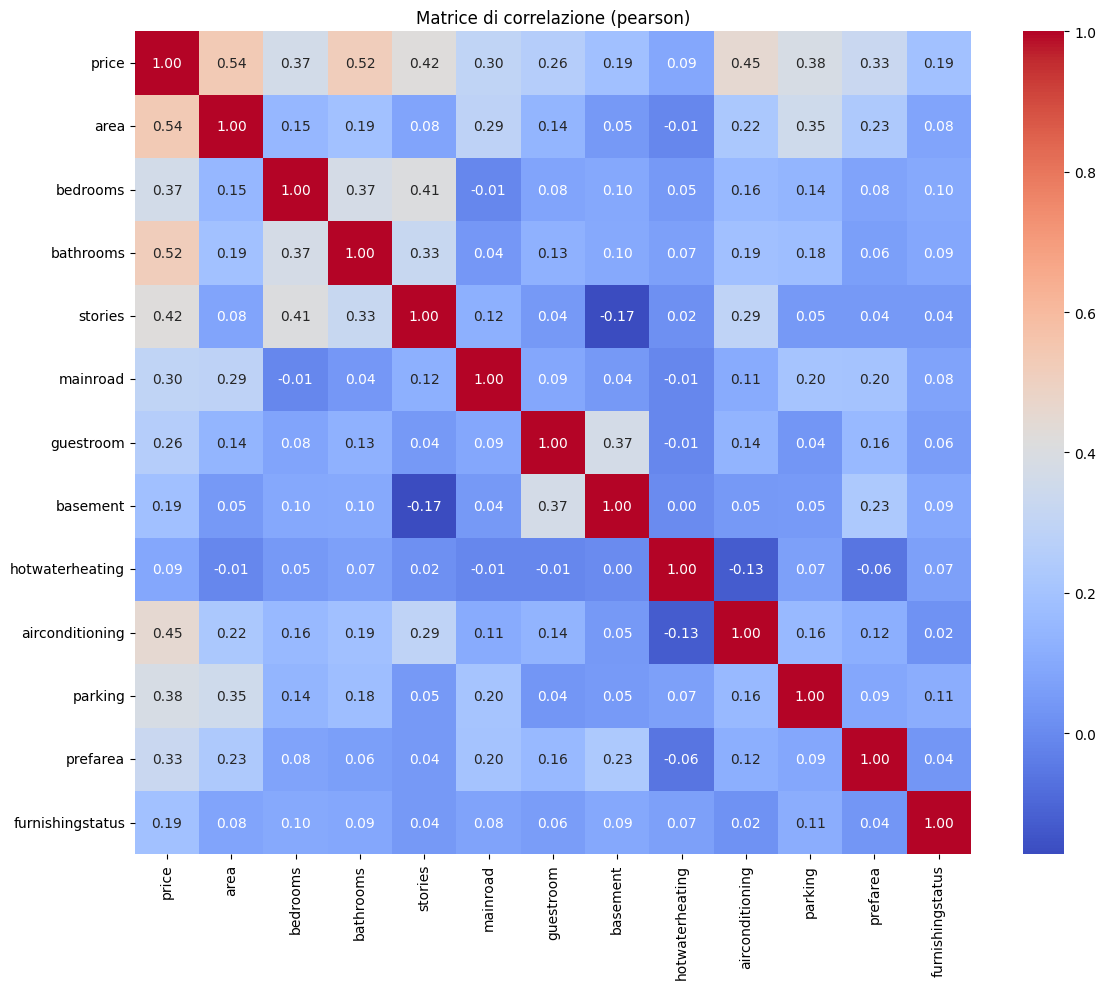

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
price,1.000000,0.535997,0.366494,0.517545,0.420712,0.296898,0.255517,0.187057,0.093073,0.452954,0.384394,0.329777,0.190086
area,0.535997,1.000000,0.151858,0.193820,0.083996,0.288874,0.140297,0.047417,-0.009229,0.222393,0.352980,0.234779,0.081367
bedrooms,0.366494,0.151858,1.000000,0.373930,0.408564,-0.012033,0.080549,0.097312,0.046049,0.160603,0.139270,0.079023,0.097834
bathrooms,0.517545,0.193820,0.373930,1.000000,0.326165,0.042398,0.126469,0.102106,0.067159,0.186915,0.177496,0.063472,0.089418
stories,0.420712,0.083996,0.408564,0.326165,1.000000,0.121706,0.043538,-0.172394,0.018847,0.293602,0.045547,0.044425,0.043288
mainroad,0.296898,0.288874,-0.012033,0.042398,0.121706,1.000000,0.092337,0.044002,-0.011781,0.105423,0.204433,0.199876,0.079403
guestroom,0.255517,0.140297,0.080549,0.126469,0.043538,0.092337,1.000000,0.372066,-0.010308,0.138179,0.037466,0.160897,0.057513
basement,0.187057,0.047417,0.097312,0.102106,-0.172394,0.044002,0.372066,1.000000,0.004385,0.047341,0.051497,0.228083,0.093425
hotwaterheating,0.093073,-0.009229,0.046049,0.067159,0.018847,-0.011781,-0.010308,0.004385,1.000000,-0.130023,0.067864,-0.059411,0.069076
airconditioning,0.452954,0.222393,0.160603,0.186915,0.293602,0.105423,0.138179,0.047341,-0.130023,1.000000,0.159173,0.117382,0.020887


In [33]:
#  Matrice di correlazion Heatmap, verifichiamo se tutte le feature sono interessanti per costruire il modello
import matplotlib.pyplot as plt
import seaborn as sbr

MatriceCorrelazione(df)

#Sembra che le feature in generale non abbiamo grande correlazione, tranne pochi casi come area, bathrooms ecc

In [34]:
#la correlazione tra price e hotwaterheating sembra essere molto bassa, lo stesso hotwaterheating ha bassa correlazione con il resto delle features
#decido di eliminare hotwaterheating riducendo la complessità.

df.drop("hotwaterheating",axis=1,inplace=True)
df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,1,2,1,1
1,12250000,8960,4,4,4,1,0,0,1,3,0,1
2,12250000,9960,3,2,2,1,0,1,0,2,1,2
3,12215000,7500,4,2,2,1,0,1,1,3,1,1
4,11410000,7420,4,1,2,1,1,1,1,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,1,0,1,0,2,0,0
541,1767150,2400,3,1,1,0,0,0,0,0,0,2
542,1750000,3620,2,1,1,1,0,0,0,0,0,0
543,1750000,2910,3,1,1,0,0,0,0,0,0,1


Vediamo la distribuzione del prezzo, è importante che sia una distribuzione pressochè normale.

Mi creo una funzione per la distribuzione, mi creo durante l'esercizio diverse funzioni per usarle anche in futuro su altri esercizi

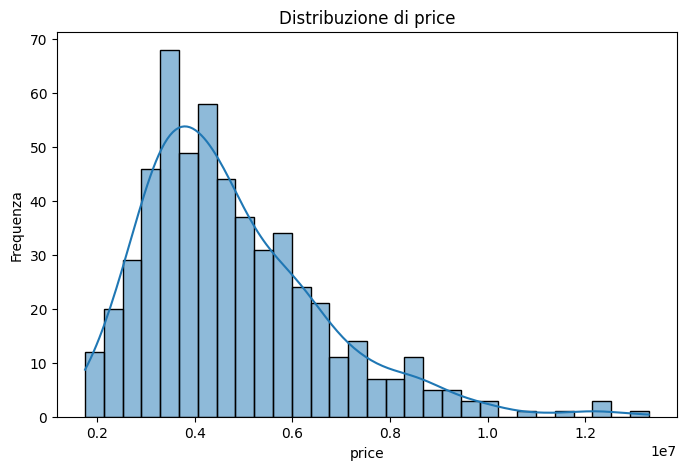

In [35]:
DistribuzioneFeature(df,"price")

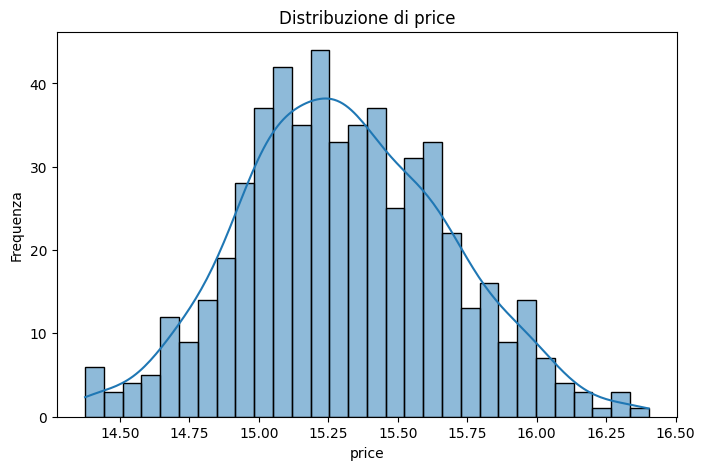

In [36]:
#Sono molto frequenti valori alti, buttando la distribuzione tutta a sinistra, è il caso di normalizzare price secondo me
#Ovviamnente poi quando useremo il modello definitivo dovremmo decodificare la previsione

df['price'] = np.log(df['price'])

#Riverifichiamo la distribuzione
DistribuzioneFeature(df,"price")

E' ovvio che dobbiamo standardizzare, area ha valori completamente differenti e il modello potrebbe pesarlo di piu peggiorando le prestazioni
Lo facciamo dopo, prevedo che su cross validation dobbiamo farlo per ogni fold quindi non lo facciamo in anticipo ma appena prima di fare l'addestramento

Mi creo una funzione per avere in output il modello vuoto, visto che devo fare diverse prove

In [37]:
#Mi creo i dati per fare verifica Hold out e Cross validation per vedere l'overfitting
# mi creao  X e y totali per la cross validation
X=df.drop("price", axis='columns').values
y=df["price"].values

In [38]:
# Dividiamo train e test (30%), intanto mi preparo i dai per l'Hold Out per verificare
from sklearn.model_selection import train_test_split

features=["area","bedrooms","bathrooms","stories","mainroad","guestroom","basement","airconditioning","parking","prefarea","furnishingstatus"]
X_train, X_test, y_train, y_test=train_test_split(df[features],df["price"],test_size=0.3,random_state=0)

Inizierei verificando l'effettivo overfitting dichiarato dall'esercizio
Creo una funzione che valuta metriche e residui, cosi vediamo tutto

A quanto vedo non ci sono segnali di overfitting, abbiamo un R2 di 0.72 su train e un buon 0.66 su test, non è overfittato altrimenti dovremmo avere valori tendenzialmente distrastrosi su test

Non sembra esserci overfitting, il modello è buono, non c'è bias nei residui, infatti vediamo forma a campana

Abbastanza casuale la relazione tra i predetti e gli errori/residui (non ci sono pattern di errore)

📈 TRAIN
MAE:  0.1670
MSE:  0.0458
RMSE: 0.2141
R²:   0.6697
----------------------------------------
🧪 TEST
MAE:  0.1492
MSE:  0.0373
RMSE: 0.1932
R²:   0.7277


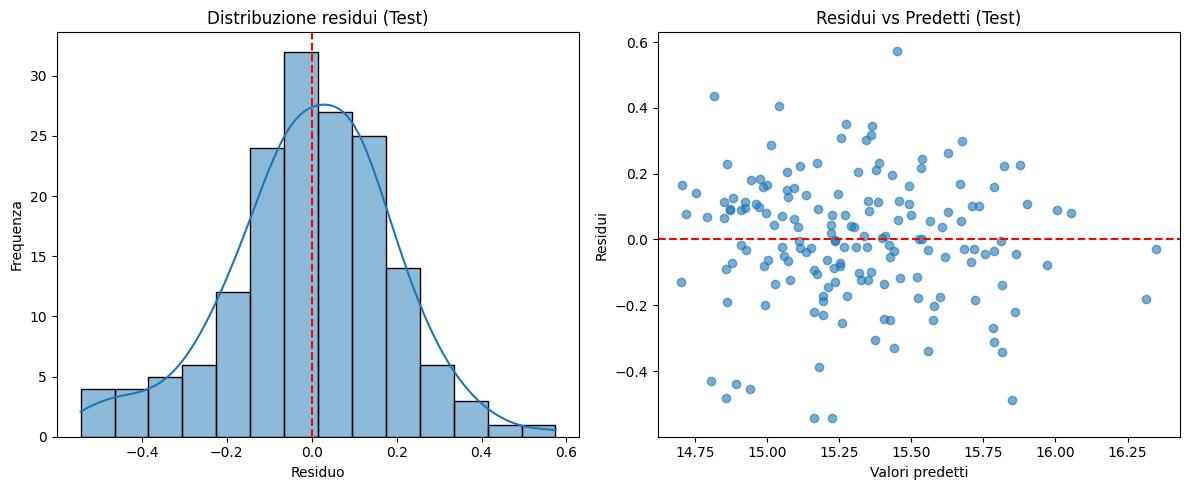

In [39]:
ValutaModelloResidui(get_model("linear"), X_train, X_test, y_train, y_test,standardizza=True)

Creo una funzione, come visto a lezione, di cross validation manuale per standardizzare i gruppi separatamente ed evitare data leakage. Ogni set deve essere fittato separatamente e trasform sul set di test

In [40]:
#Vedo cosa mi dice la cross validation, se generalizza in media sull'insieme di train
#Standardizzo all'interno della funzione nei fold per evitare data leakage

#Anche su tutto il set, faccio validazione incrociata separando in gruppi, il risultato è buono

cross_validate_kfold(get_model("linear"),X=X,y=y,k=10)

{'train_scores': array([0.68729803, 0.68764514, 0.67497741, 0.69529215, 0.68184308,
        0.68933381, 0.69981557, 0.68627668, 0.69677568, 0.68626087]),
 'test_scores': array([0.69361929, 0.68912449, 0.7793923 , 0.63301089, 0.72459594,
        0.66150071, 0.52144299, 0.69539997, 0.59563767, 0.70438991]),
 'train_mean': np.float64(0.6885518422513143),
 'test_mean': np.float64(0.6698114157320729)}

Io sinceramente non vedo overfitting, vediamo comunque con lasso,ridge e elastic net se miglioriamo R2

All'aumentare di alpha non c'è nessun miglioramento con ridge, anzi peggioramento da alpha 10 a infinito
Forse la feature selection con Lasso migliora il modello? proviamo

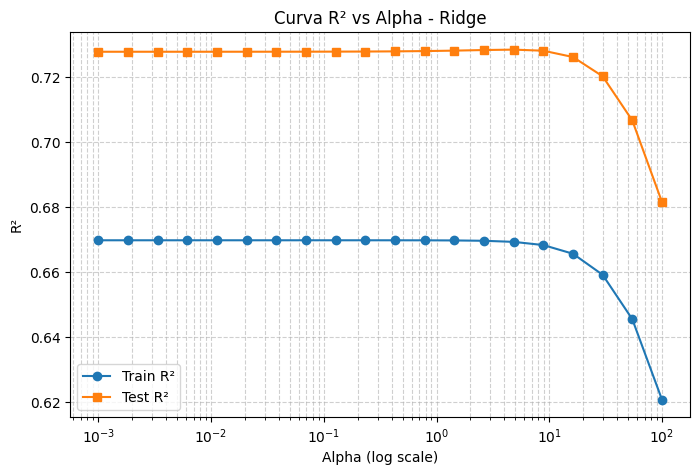

In [41]:
plot_r2_vs_alpha(get_model("ridge"),X_train,X_test,y_train,y_test)

Giusto per prova di quello che ho appena scoperto faccio CV sull'intero set su ridge, difatti inizia a peggiorare ad aplha=100

In [42]:
cross_validate_kfold(get_model("ridge",alpha=100),X=X,y=y,k=5)

{'train_scores': array([0.68137581, 0.67264086, 0.67571833, 0.69253543, 0.68911629]),
 'test_scores': array([0.68136697, 0.68989594, 0.6785802 , 0.63624599, 0.64534999]),
 'train_mean': np.float64(0.6822773435555207),
 'test_mean': np.float64(0.6662878195602776)}

usiamo lasso l1, neanche lasso porta benefici.... ha poco senso fare elastic net. 
Almeno sappiamo che non c'è feature selection da fare. Andiamo avanti con Elatic net come da esercizio anche se a questo punto serve a poco immagino

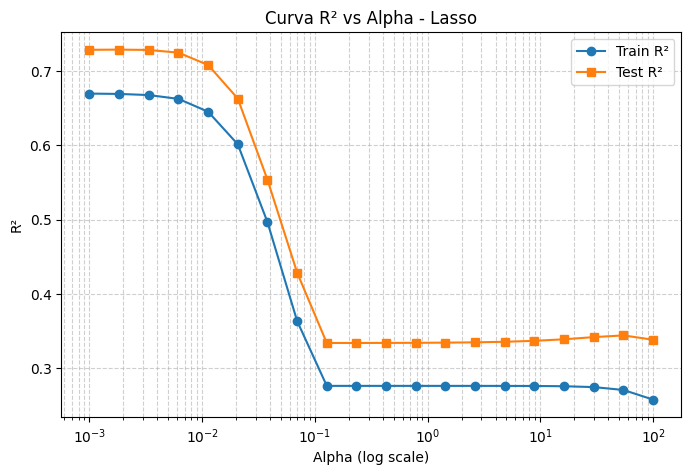

In [43]:
plot_r2_vs_alpha(get_model("lasso"),X_train,X_test,y_train,y_test)

Giusto per prova di quello che ho appena scoperto faccio CV sull'intero set su ridge, difatti inizia a peggiorare ad aplha=0.1

In [44]:
cross_validate_kfold(get_model("lasso",alpha=0.1),X=X,y=y,k=5)

{'train_scores': array([0.40195861, 0.37615906, 0.38419457, 0.40703331, 0.39917809]),
 'test_scores': array([0.47392578, 0.34574121, 0.38186   , 0.36110175, 0.34924005]),
 'train_mean': np.float64(0.3937047269622889),
 'test_mean': np.float64(0.3823737581699108)}

A questo punto, mi sembra ovvio che Elastic net non possa funzionare, setto comunque lamda=0.5 per pesare allo stesso modo lasso e ridge e provo per tutti gli alpha

PS: l1_ration è gia di default a 0.5, pero lo faccio vedere comunque (anche per mia tracciabilità futura)

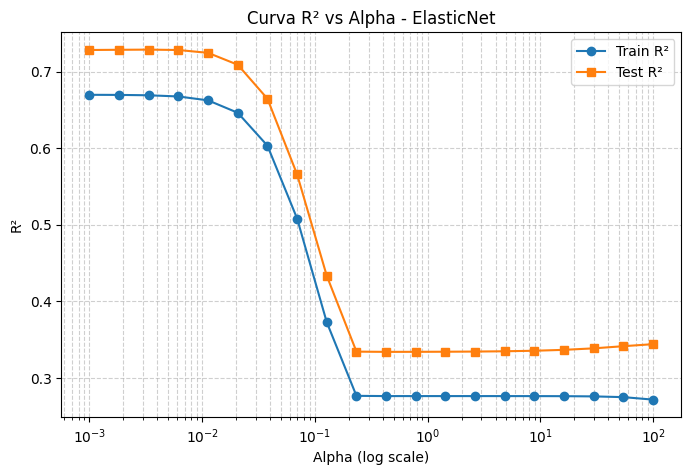

In [45]:
plot_r2_vs_alpha(get_model("elasticnet",l1_ratio=0.5),X_train,X_test,y_train,y_test)

La curva di apprendimento sotto ci mostra che c'è overfitting inziale ovviamente con pochi dati poi il modello migliora nella previsione di dati sconosciuti

Sembra un buon modello, penso anche che aumentando i dati non aumenterebbe significatamente R2

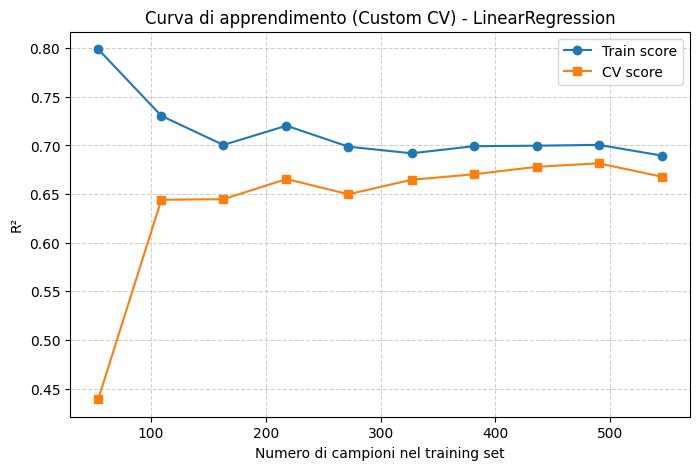

In [46]:
plot_learning_curve(get_model("linear"),X,y)

In [47]:
# Quindi, il miglior modello è la reg multipla semplice, nessun coefficiente non nullo

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

modello_finale=get_model("linear").fit(X_std,y)

# Coefficienti (uno per ogni feature)
print("Coefficienti:", modello_finale.coef_)

# Intercetta
print("Intercetta:", modello_finale.intercept_)

Coefficienti: [0.1080333  0.0227398  0.08490926 0.08011661 0.04215988 0.02763
 0.04389769 0.07770557 0.04279925 0.05251778 0.05479237]
Intercetta: 15.306986880099473
